## TASK 2 - Image stitching

Group Number: 4

### 1. Data import and SIFT Extraction

Complete ***get_panorama_data(..)*** in _dataset.py_ to read the images and extract the SIFT keypoints and descriptors per image. Check your implementation by plotting the result using ***utils.plot_keypoints(..)***.


***Submission:*** Save the *second* image (from left) of the campus dataset as **task2_keypoints.png** using ***utils.plot_keypoints(..)***.

In [14]:
%load_ext autoreload
%autoreload 1
%aimport transforms, panorama, mapping, dataset, utils
import matplotlib.pyplot as plt
import numpy as np
import transforms
import panorama
import mapping
import dataset
import utils
import cv2

plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 150

data_path = 'data/office'
# data_path = 'data/office_rot'
# data_path = 'data/campus'
# data_path = 'data/campus_rot'
# data_path = 'data/snow_complex'
# data_path = 'data/schonbrunn'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


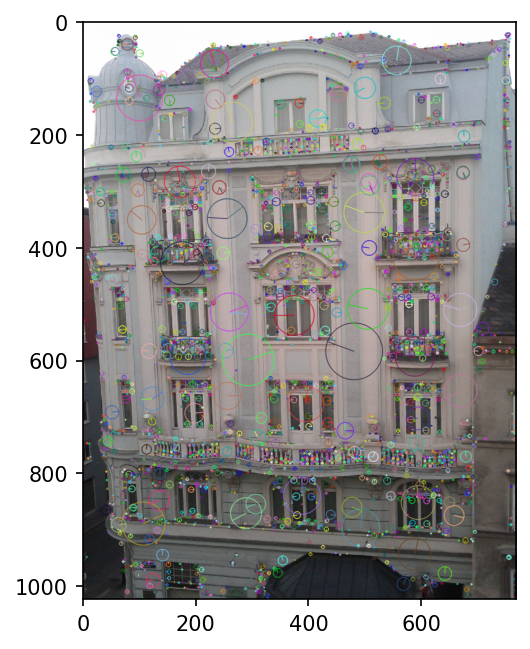

Number of images:  5
Keypoints length:  2725
Descriptor shape:  (2725, 128)


In [15]:
#student_code start

images, keypoints, descriptors = dataset.get_panorama_data(data_path)
utils.plot_keypoints(images[1], keypoints[1])
# utils.plot_keypoints(images[1], keypoints[1], group_no='Group_4', name='task2_keypoints')

#student_code end

# check import
print('Number of images: ',len(images))
print('Keypoints length: ', len(keypoints[0]))
print('Descriptor shape: ',descriptors[0].shape)

***
#### What is the meaning of the size of the drawn circles and lines inside the circles?

The size of the circle represents the scale with which the keypoint is identified, whereas the line represents its orientation.
In particular, an orientation histogram is computed over a region surrounding the interest point and the line is drawn according to its peak.
It could be that there are more than one line for the same position if a second peak within 80% of the maximum is present.

#### 1.1 Matching

Let's take a look at the matching. Plot the matches between two adjacent images using ***mapping.calculate_matches(..)*** and ***utils.plot_matches(..)***.


***Submission:*** Save plot of matches between the *second and the third image* image of the campus dataset as **task2_matches.png** using ***utils.plot_matches(..)***.


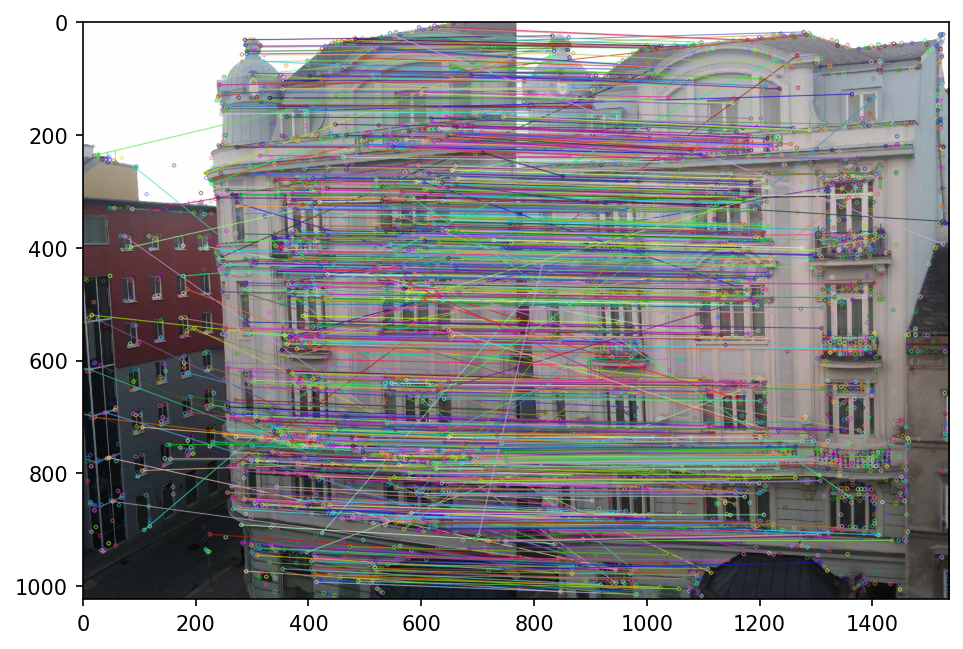

In [16]:

index1 = 0
index2 = 1

#student_code start

list_of_matches = mapping.calculate_matches(descriptors[index1], descriptors[index2])
utils.plot_matches(images[index1], images[index2], keypoints[index1], keypoints[index2], list_of_matches)
# utils.plot_matches(images[index1], images[index2], keypoints[index1], keypoints[index2], list_of_matches, group_no='Group_4', name='task2_matches')

#student_code end

***
#### Describe below how the matching, based on LOWE, works.

To find the matching we consider a list of descriptors of keypoints of the two images with their respective descriptors. Keypoints of the first image are matched with keypoints of the second images and the two shortest matches are kept. After this, the Lowe ratio, ratio between the legths of shortest and second-shortest match, is computed and if iit is below a certain threshold we keep the shortest match otherwise we discard it.
The idea is that if the first match is significantly shorter that the second one, then it is probable that there is a real correspondence between the two points.

### 2. Image Registration using RANSAC

As you can see in the keypoint matching plot above, the matching algorithm still has some wrong connections. To remove those outliers, you will implement RANSAC and use the remaining inliers to estimate a final tranformation matrix (homography) between two given images. Implement RANSAC in ***get_transform(..)*** in _transforms.py_.

Check your implementation by plotting the result using ***utils.plot_matches(..)***.


***Submission:*** Save a plot showing the matches between the *second and the third image* of the campus dataset again, using the calculated inliers, as **task2_matches_ransac.png** using ***utils.plot_matches(..)***.

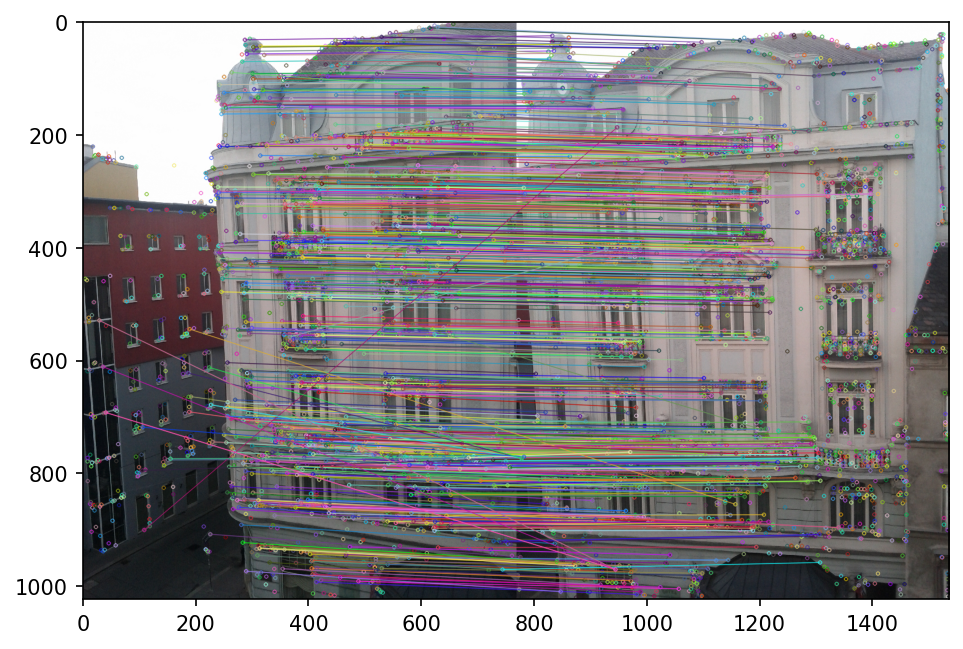

In [17]:

#student_code start

trans, inliers = transforms.get_transform(keypoints[index1], keypoints[index2], list_of_matches)
utils.plot_matches(images[index1], images[index2], keypoints[index1], keypoints[index2], inliers)
# utils.plot_matches(images[index1], images[index2], keypoints[index1], keypoints[index2], inliers, group_no='Group_4', name='task2_matches_ransac')

#student_code end

***
#### What is the difference to the set of all putative matches you plotted before?

Rasnac let to remove from the list of matches those which are considered as outliers, or in other words to keep only matches which are more alligned with the dominant direction. The image above shows how it can be really effective in removing crossing edges.

#### 2.1 Align Images

Test your homography after RANSAC by transforming a chosen image to the corresponding image on the right and plot with ***transforms.plot_transformed_image(..)***.

_***HINT:***_
_cv2.warpPerspective(..)_


***Submission:*** Save the second image of the campus dataset transformed onto the third one as **task2_matches_transformed.png** using ***utils.plot_transformed_image(..)***.

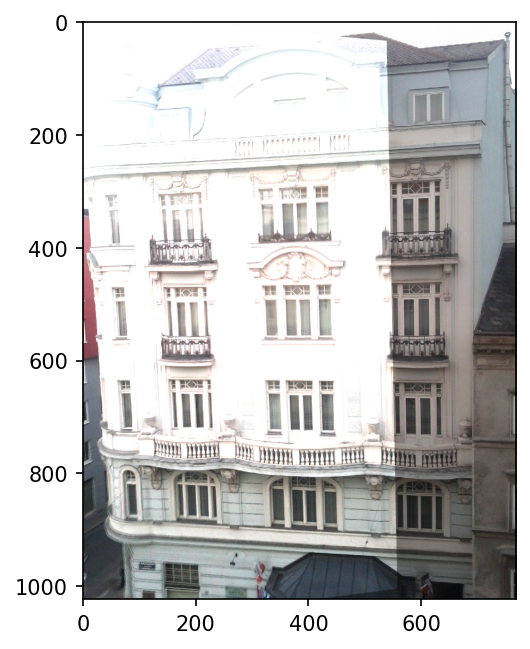

In [18]:
#student_code start

img_1 = cv2.warpPerspective(images[index1], trans, dsize=images[index2].shape[:2][::-1])
utils.plot_transformed_image(img_1, images[index2])
# utils.plot_transformed_image(img_1, images[index2], group_no='Group_4', name='task2_matches_transformed')

#student_code end

### 3. Image Stitching

Before, you implemented the basics to calculated homographies between two images. Further, transform all images to a reference image, usually the center one, to get a balanced panorama. Implement and use the method ***to_center(..)*** in _transforms.py_ to get all homographies to the center image.


In [19]:
#student_code start

images, keypoints, descriptors = dataset.get_panorama_data(data_path)
H_center = transforms.to_center(descriptors, keypoints)

#student_code end

#### Panorama Extents

One final step before panorama composition is to estimate the final panorama size based on the obtained homographies. Implement ***transforms.get_panorama_extents(..)***

In [20]:
#student_code start

T, width, height = transforms.get_panorama_extents(images, H_center)

#student_code end

print("Panorama dimension: ", height, " ",width)

Panorama dimension:  1442   2147


#### Simple Panorama  

Here is where the magic happens. Using the homographies, translation matrix and panorama extents, you can now stitch the images to a panorama. Implement ***panorama.get_simple(..)*** and check your result with ***utils.plot_panorama(..)***.

***Submission:*** Save the campus panorama as **task2_panorama_simple.png** using ***utils.plot_panorama(..)***.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


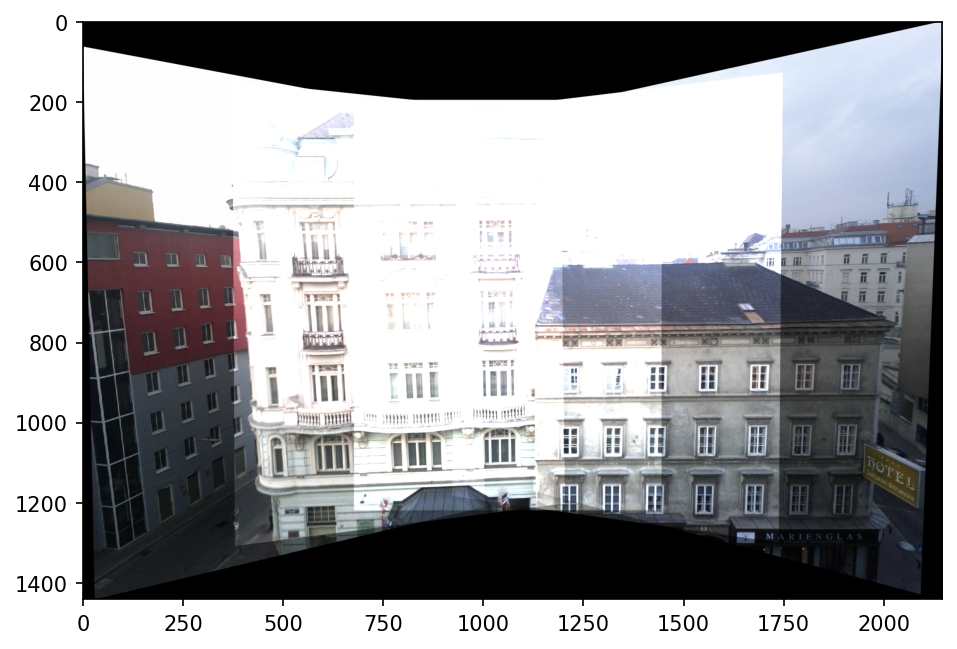

In [26]:
#student_code start

result = panorama.get_simple(images, width, height, H_center, T)
utils.plot_panorama(result)
# utils.plot_panorama(result, group_no='Group_4', name='task2_panorama_simple')

#student_code end

### 4. Panorama Feathering

The simple panorama might look geometrically correct, but not pleasant enough yet. The intensities are simply stacked. Implement a color blending method to improve the panorama output. 

Complete ***panorama.get_blended(..)*** and check your result with ***utils.plot_panorama(..)***.

***Submission:*** Save the improved blended campus panorama as **task2_panorama_blended.png** using ***utils.plot_panorama(..)***.

c:\Users\nicol\OneDrive\Desktop\Computer-Vision-183.585\TASK2\panorama.py:96: RuntimeWarning: invalid value encountered in divide
  alpha_masks = [alpha/sum_alpha for alpha in alpha_masks]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


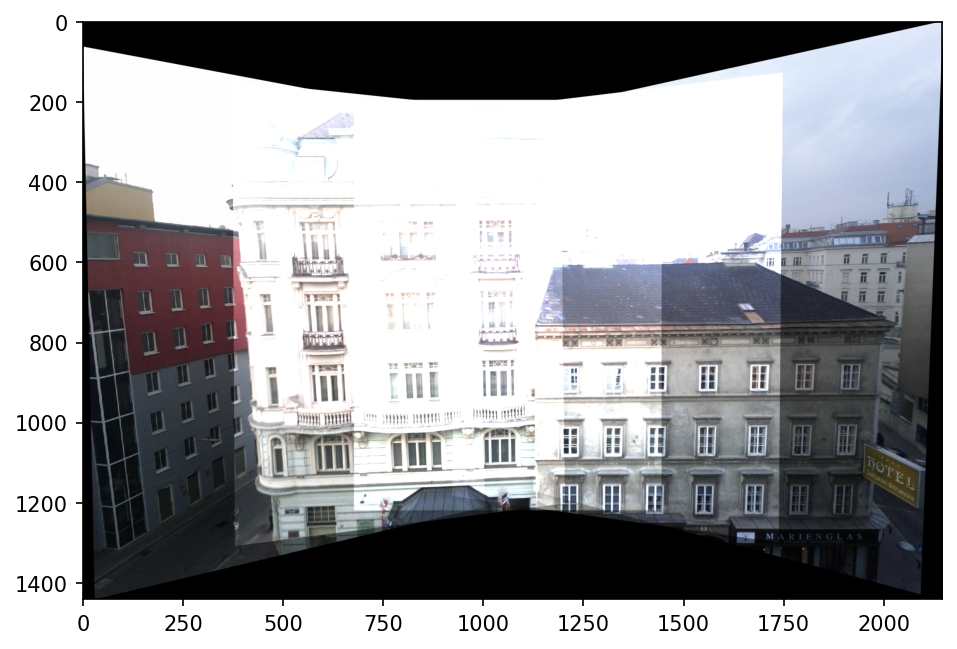

In [27]:
#student_code start

result_1, pecies = panorama.get_blended(images, width, height, H_center, T)
utils.plot_panorama(result)
# utils.plot_panorama(result, group_no='Group_4', name='panorama_own')

#student_code end


***
#### Compare the result achieved with feathering to the result where no blending has been performed. What is the difference of the two results?

The first result is obtained summing each transformed images, therefore the value of each pixel is the sum of the pixel values in that position in each partial component. Pixels which recieve contributions from more than one image appear brigther, therefore parts of the final image where there are more overlaps looks almost white. In the second result the contribution of each component is weighted, therefore overlapping parts are better blended.

***
#### Examine if the presented scheme of SIFT interest point detection and RANSAC-based alignment is invariant to changes in image rotation and scale. Thus, resize and rotate the second image of the campus dataset and repeat the panorama process. What do you observe?

***Submission:*** Save the resulting panorama with the rotated images as file ***panorama_rotated_blended.png*** (feathered)

The final panorama looks nicely blended and this because the method is both scale and rotation invariant.

***
#### Once again, repeat the panorama procedure with your own image sequence. Save and discuss the achieved results. The result might look quite realistic at a first glance but can you spot any errors by looking on details?

***Submission:*** Save the resulting panorama as file ***panorama_own.png*** (feathered) 

The result is quite realistic but the overall resolution is not so high. Objects on the border of two images are not perfectly matched and moving objects give rise to some incongruences.

C:\Users\nicol\AppData\Local\Temp\ipykernel_26636\2134612348.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,len(pecies),i+1)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Blended panorama')

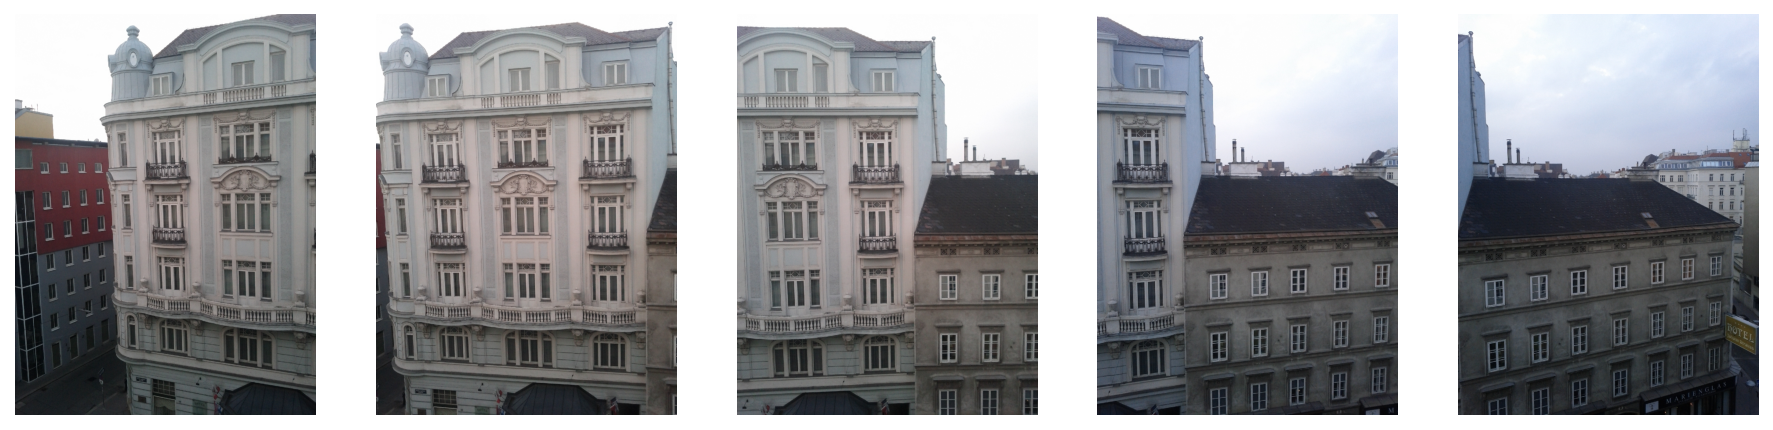

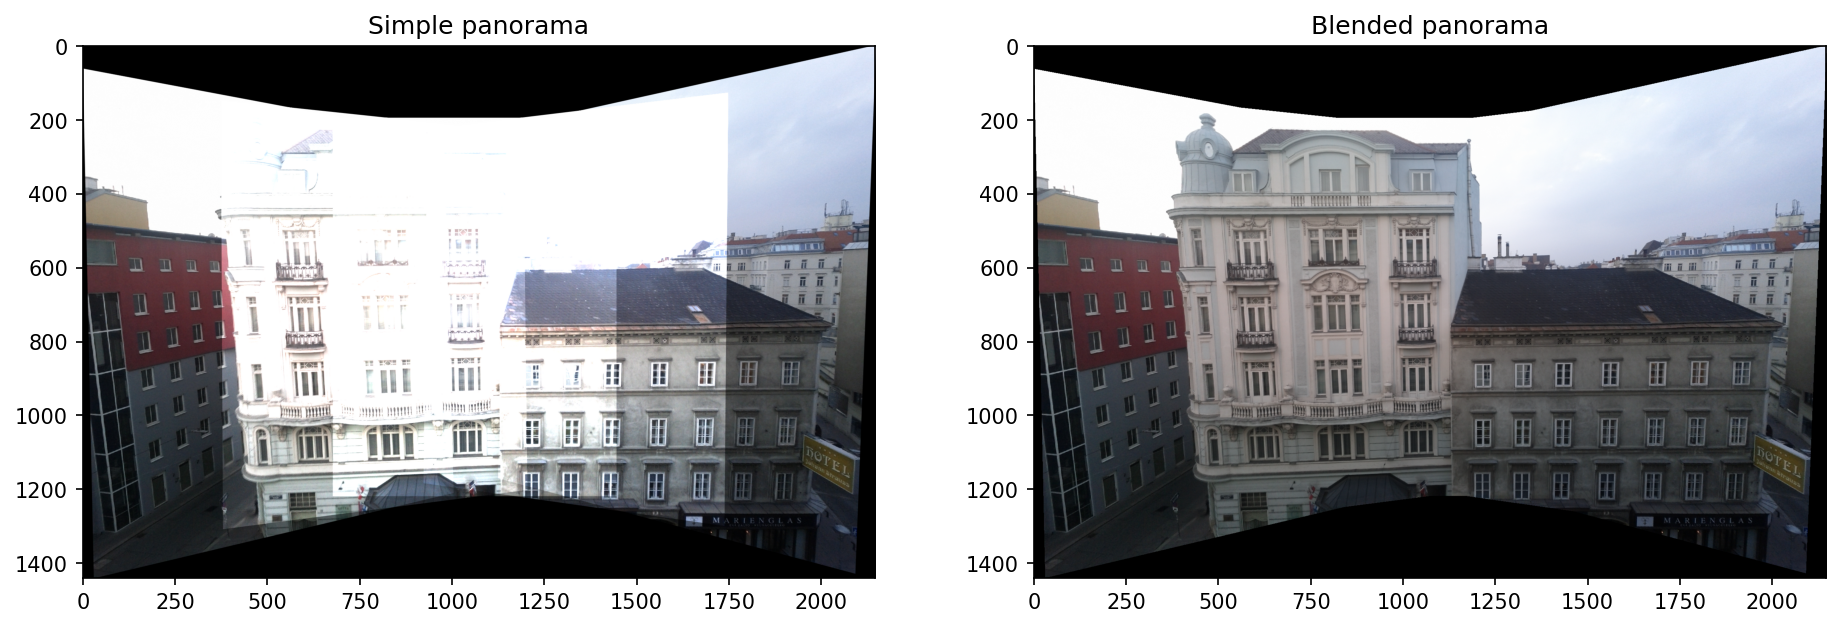

In [33]:
plt.figure(figsize=(15,5))
plt.title('Images of a panorama')
for i in range(len(images)):
    plt.subplot(1,len(pecies),i+1)
    plt.imshow(images[i])
    plt.axis('off')

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(result)
plt.title('Simple panorama')
plt.subplot(1,2,2)
plt.imshow(result_1)
plt.title('Blended panorama')